In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from config import DATA

# Explore corrupted data set

In [2]:
# Load the data
data = np.load(DATA["corrupted"])

In [3]:
# Print the shape of the data
data.shape

(126300, 28, 28)

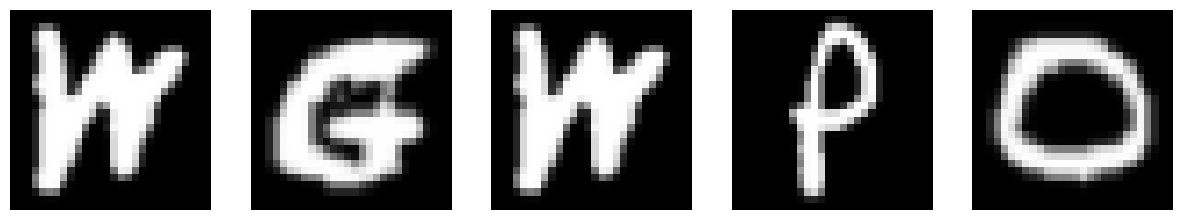

In [4]:
# Print 5 pictures to check dataset
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axes[i].imshow(data[i], cmap='gray')
    axes[i].axis('off')

plt.show()

It seems like we are working with 126.3k letters represented as 28x28 pixel grey scale images

# Predictions of VAE model

In [5]:
preds = np.load(DATA["corrected"])

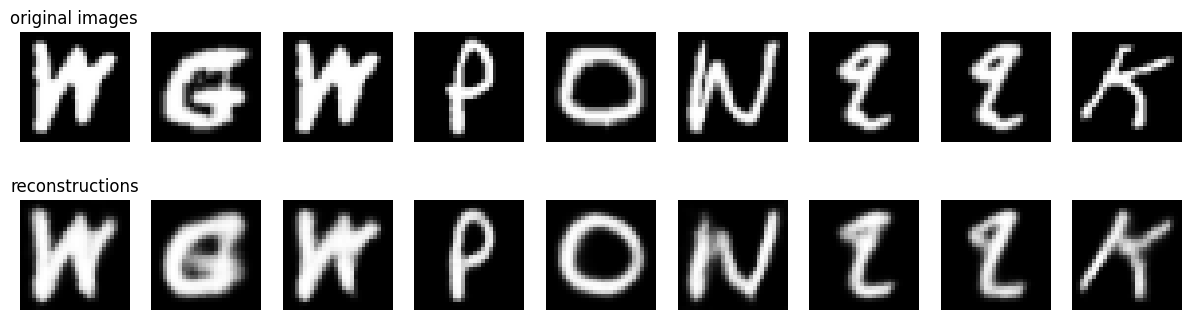

In [6]:
# plot reconstructed vs actual images
fig, axes = plt.subplots(2, 9, figsize=(15, 4))

for i in range(9):
    axes[0][i].imshow(data[i], cmap='gray')
    axes[0][i].axis('off')

    axes[1][i].imshow(preds[i], cmap='gray')
    axes[1][i].axis('off')

axes[0][0].set_title("original images")
axes[1][0].set_title("reconstructions")
plt.show()

# Anomalous masks & scores

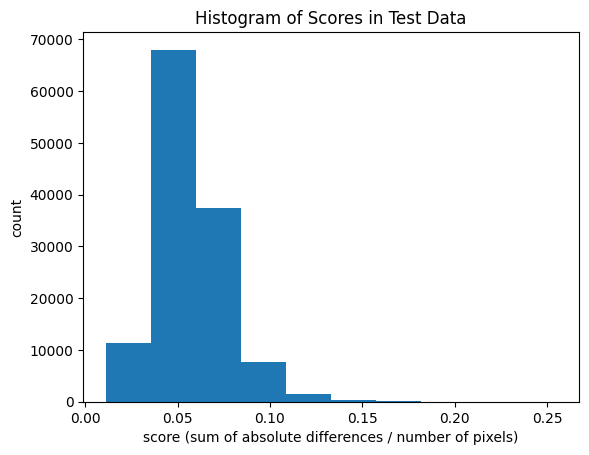

In [7]:
scores = torch.load(DATA["scores"])

plt.hist(scores)
plt.title("Histogram of Scores in Test Data")
plt.ylabel("count")
plt.xlabel("score (sum of absolute differences / number of pixels)")
plt.show()

We used 0.15 as threshold condition to filter for the most siginificant changes in the images while having a limited amount of pictures that allows us to manually detect patterns in the changes. Later on, one could also try to take into account lower thresholds and to see if there are other alteractions present or apply different methods for obtaining the scores. For instance, filtering for the density of changes per area or the magnitude of differences is single pixels could leed to the discovery of new altercation patterns that are not detected with method used here.

In [8]:
masks = torch.load(DATA["masks"])
preds = torch.load(DATA["preds"])
trues = torch.load(DATA["trues"])
cond = torch.load(DATA["cond"])

anomalous_masks = masks[cond]
anomalous_preds = preds[cond]
anomalous_trues = trues[cond]
anomalous_scores = scores[cond]

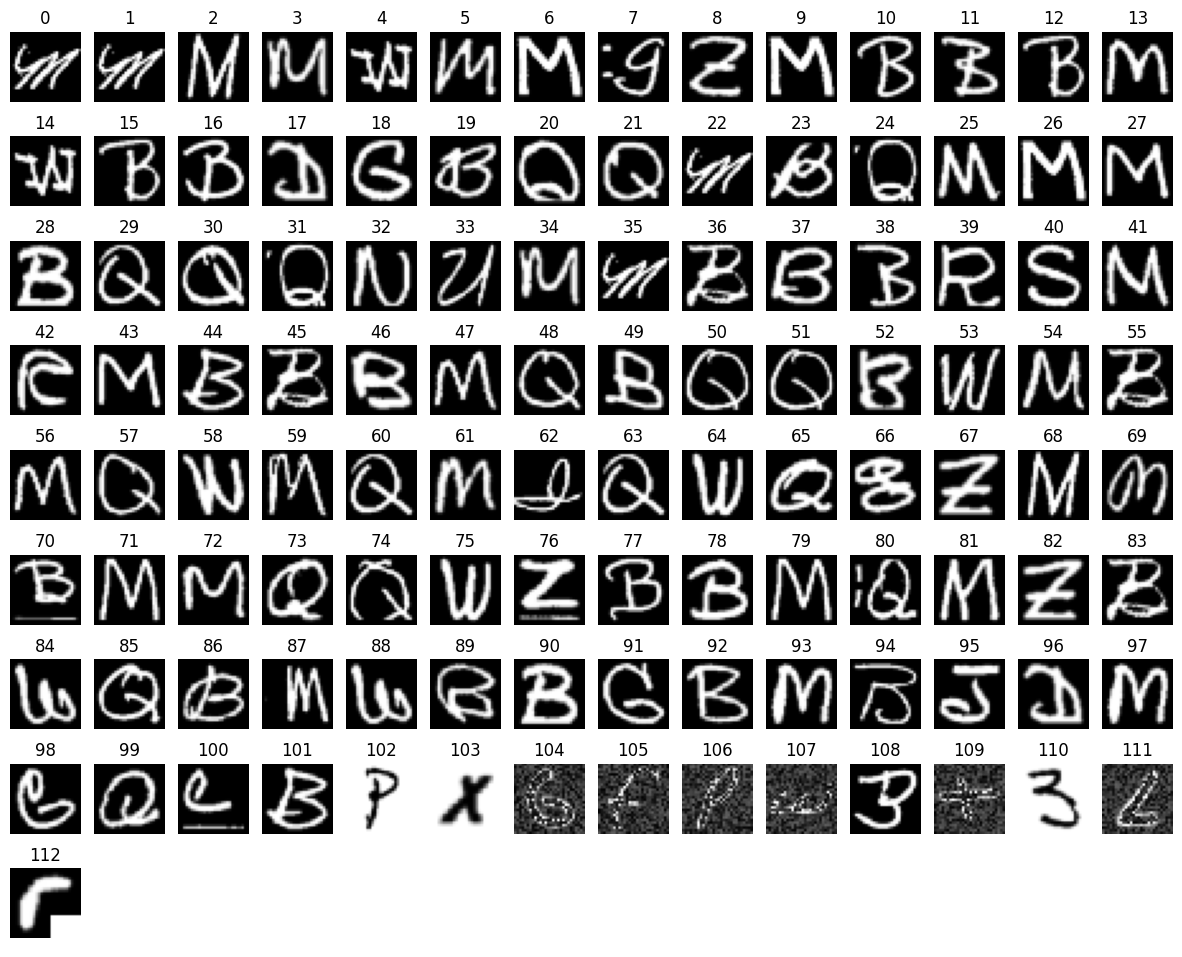

In [12]:
fig, axes = plt.subplots(9, 14, figsize=(15, 12))
for i, ax in enumerate(axes.flatten()):
    if i < anomalous_scores.shape[0]:
        ax.imshow(anomalous_trues[i][0].detach().numpy(), cmap='gray')
        ax.set_title(i)
    ax.axis('off')

We get some interesting insights by looking at this first list of anomalous images. We can see that there are some characters that seem to not be corrupted imges, e.g. a lot of "M" and "W" that might be difficult to learn for VAE to distinguish. The same can be said for "B" or special ways to write a character (such as image 4, 62 and 66 which can be assumed to be unconvential ways to write the letters "W", "G", and "G" respectively).

Furthermore, we can identify corrupt images:

- inverse of black and white pixels (102, 103, 110)
- added some noise over all the image (e.g., 104 - 107, 109, 111)
- random areas (105)
- underscores (70, 76, 100)
- dots in image (7, 24, 31, 80)

Not all of them might be created during the corruption, but especially the later ones might already be present in the original EMNIST data set. However, the are not "normal" anyways and we'll try to rebuild them after looking at some examples more closely.

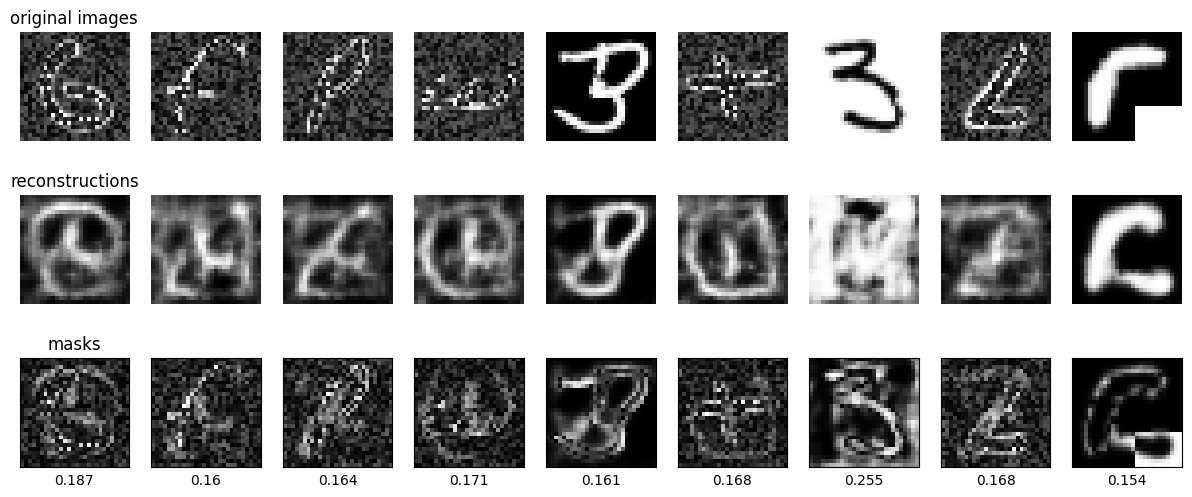

In [10]:

# plot some examples of original, reconstructed and mask (incl. score)
fig, axes = plt.subplots(3, 9, figsize=(15, 6))

for i in range(9):
    axes[0][i].imshow(anomalous_trues[-9:][i][0].detach().numpy(), cmap='gray')
    axes[0][i].axis('off')


    axes[1][i].imshow(anomalous_preds[-9:][i][0].detach().numpy(), cmap='gray')
    axes[1][i].axis('off')

    axes[2][i].imshow(anomalous_masks[-9:][i].detach().numpy(), cmap='gray')
    axes[2][i].set_xlabel(round(anomalous_scores[-9:][i], 3))
    axes[2][i].set_xticks([])
    axes[2][i].set_yticks([])

axes[0][0].set_title("original images")
axes[1][0].set_title("reconstructions")
axes[2][0].set_title("masks")
plt.show()